## AutoGluonImputer

This package offers a sophisticated solution for handling missing data in datasets using the AutoGluon TabularPredictor. It's adept at working with both numerical and categorical data and provides a machine-learning-driven approach for imputation.


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from autogluonImputer import Imputer 
from AutoGluon import TabularDataset

#### Step 2: Prepare the Data


In [17]:

# Load the data
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target
df=TabularDataset(df)


In [ ]:

# Split the data into train and test sets
train, test = train_test_split(df, test_size=0.3, random_state=42)

# Introduce missingness
train_missing = train.mask(np.random.random(train.shape) < 0.2)
test_missing = test.mask(np.random.random(test.shape) < 0.2)


## Step 3: Impute Missing Values

In [18]:
imputer = Imputer(num_iter=2, time_limit=10)
train_imputed = imputer.fit(train_missing)
test_imputed = imputer.transform(test_missing)

No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152333/"


Fitting the imputer to the data...


No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152346/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152358/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152410/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152422/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152434/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152445/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152459/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152510/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152523/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152537/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152550/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152604/"
No path specifie

Latitude
MedInc
AveRooms
Population
target
AveOccup
HouseAge
AveBedrms
Longitude
AveBedrms
Longitude
Population
target
HouseAge
AveRooms
AveOccup
Latitude
MedInc


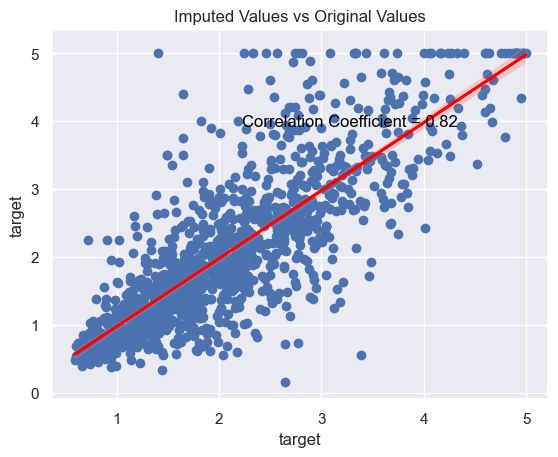

In [19]:
# Compare imputed values with original values for the target variable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Identify missing indices in test dataset
missing_indices_test = test_missing['target'].index[test_missing['target'].apply(np.isnan)]

# Plot imputed values against original values
plt.scatter(test_imputed['target'][missing_indices_test], test['target'][missing_indices_test])
plt.xlabel('Imputed Values')
plt.ylabel('Original Values')
plt.title('Imputed Values vs Original Values')
sns.regplot(x=test_imputed['target'][missing_indices_test], y=test['target'][missing_indices_test], scatter=False, color='red')
# Calculate and display the correlation coefficient
corr = np.corrcoef(test_imputed['target'][missing_indices_test], test['target'][missing_indices_test])[0,1]
plt.text(.6, .75, f'Correlation Coefficient = {round(corr, 2)}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='black')
plt.show()

In [20]:
# table of imputed values for HouseAge against original values only for the missing indices
missing_indices_test = test_missing['HouseAge'].index[test_missing['HouseAge'].apply(np.isnan)]
pd.DataFrame({'Imputed Values': test_imputed['HouseAge'][missing_indices_test], 'Original Values': test['HouseAge'][missing_indices_test]})
# now the cross table
pd.crosstab(test_imputed['HouseAge'][missing_indices_test], test['HouseAge'][missing_indices_test])


HouseAge,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,...,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0
HouseAge,,,,,,,,,,,,,,,,,,,,,
2.0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,2,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5.0,0,2,1,2,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8.0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10.0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11.0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
13.0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# multiple imputation

In [21]:
from autogluonImputer import multiple_imputation
num_iter=2
time_limit=10
train_imputed = multiple_imputation(train_missing, n_imputations=2, num_iter=num_iter, time_limit=time_limit)


No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152721/"


Performing imputation 1/2
Fitting the imputer to the data...


No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152732/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152744/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152755/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152809/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152821/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152833/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152845/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152858/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152909/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152920/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152933/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_152948/"
No path specifie

Performing imputation 2/2
Fitting the imputer to the data...


No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153114/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153128/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153139/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153152/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153204/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153215/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153228/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153241/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153254/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153308/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153320/"
No path specified. Models will be saved in: "AutogluonModels/ag-20231029_153334/"
No path specifie

In [22]:
train_imputed[0].head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
7061,4.131200,35.0,5.882353,1.042595,1167.988770,3.172453,33.938683,-118.020000,1.938000
14689,2.863100,31.0,4.654479,1.054090,999.000000,2.747243,32.790000,-117.140518,1.697000
17323,4.939854,24.0,5.617544,0.989474,731.000000,3.067768,34.590000,-120.140000,2.598000
10056,3.109400,14.0,5.869565,1.094203,1339.710327,2.188406,39.260000,-121.000000,1.361000
15750,3.306800,52.0,4.801205,1.066265,1526.000000,2.298193,37.770000,-122.298340,2.219573


In [23]:
train_imputed[ 1].head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
7061,4.131200,35.0,5.882353,1.031859,1143.426636,3.134387,33.979156,-118.020000,1.938000
14689,2.863100,31.0,4.612317,1.040233,999.000000,2.642561,32.790000,-117.082413,1.697000
17323,5.011634,24.0,5.617544,0.989474,731.000000,2.984236,34.590000,-120.140000,2.598000
10056,3.109400,14.0,5.869565,1.094203,1391.363770,2.188406,39.260000,-121.000000,1.361000
15750,3.306800,52.0,4.801205,1.066265,1526.000000,2.298193,37.770000,-122.393303,2.714403
